In [ ]:
%pip install fastcore==1.3.19 fastai==2.2.5 rasterio geopandas shapely wandb geojson wwf -Uqq

In [ ]:
%pip install timm

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
#hide
from fastai.vision.models import *
from fastai.vision.all import *

from tqdm import tqdm
from pdb import set_trace
from pprint import pprint
from pathlib import Path
import wandb
from fastai.callback.wandb import * 

warnings.filterwarnings("ignore")

path = Path('/content/drive/My Drive/cv/cv_527/xview_data/train')
type(path)
Path.BASE_PATH = path

In [ ]:
#hide
# Checking what Google Colab is offering today :)
try:
  torch.cuda.get_device_properties(0)
except:
  print("No CUDA device available.")

In [ ]:
BATCH_SIZE = 16
TILES_PER_SCENE = 16
ARCHITECTURE = xresnet34
EPOCHS = 20
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 3e-3
ENCODER_FACTOR = 10
CODES = ['Land','Building']

In [ ]:
#hide
# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    tiles_per_scene=TILES_PER_SCENE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

In [ ]:
masks = path/'masks'

mask = masks/'socal-fire_00001352_pre_disaster.png'
image = path/'images'/'socal-fire_00001352_pre_disaster.png'
# plt.imshow(img,cmap='cividis');
# plt.imshow(np.array(PILImage.create(mask)),cmap='cividis');

f, axarr = plt.subplots(1,2, figsize=(14,14))
f.tight_layout()
axarr[0].imshow(np.array(PILImage.create(mask)))
axarr[1].imshow(np.array(PILImage.create(image)))
plt.show()
                  


In [ ]:
def get_image_tiles(path:Path, n_tiles=TILES_PER_SCENE) -> L:
  "Returns a list of the first `n` image tile filenames in `path`"
  files = L()
  masked_files = (path/'mask_tiles').ls().sorted()

  for fi in masked_files:
    files.append(Path(str(fi).replace("mask_tiles", "img_tiles3")))

  # for folder in :
  #   files.extend(get_image_files(path=folder, folders='img_tiles')[:n_tiles])
  #   print(files)
  return files

In [ ]:
def get_y_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('img_tiles3', 'mask_tiles')

def get_x_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('mask_tiles3', 'img_tiles')

In [ ]:
def get_y(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_y_fn(fn)
  msk = np.array(PILMask.create(fn))
  msk[msk==255] = 1
  return PILMask.create(msk)

def get_x(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_x_fn(fn)
  # print("fn return ", fn)
  msk = np.array(PILMask.create(fn))
  # msk[msk==255] = 1
  # return PILMask.create(msk)
  # return PILMask.create(fn)
  return (msk)


In [ ]:
def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    print("model.children() ", model.children())
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

In [ ]:
#export
from timm import create_model
from fastai.vision.learner import _update_first_layer

#exports
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    print("model.children()12 ", model.children())
    print("*list(model.children() ", *list(model.children()) )
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [ ]:
def get_input_images(path):
  mask_contained_images = []
  mask_files = (path/'mask_tiles').ls().sorted()
  non_existing_files = ['/content/drive/My Drive/projects/cv_527/xview_data/train/mask_tiles/guatemala-volcano_00000007_pre_disaster_0_2 (1).png', 'uatemala-volcano_00000001_pre_disaster_1_2 (1)']
  for mk_f in mask_files:
    if mk_f not in non_existing_files:
      new_p = Path(str(mk_f).replace("mask_tiles", "img_tiles3"))
      mask_contained_images.append(new_p)
  # print("mask_contained_images ", mask_contained_images)
  return mask_contained_images


In [ ]:
def get_target_mask(path):
  # print("path , ",path) 
  new_p = Path(str(path).replace( "img_tiles3", "mask_tiles"))
  return (new_p)

In [ ]:
ALL_VALID_NAMES = [
'mexico-earthquake_00000015_post_disaster',
'palu-tsunami_00000072_post_disaster',
'socal-fire_00000313_pre_disaster',
'hurricane-florence_00000168_pre_disaster',
'hurricane-florence_00000065_pre_disaster',
'socal-fire_00001331_pre_disaster',
'midwest-flooding_00000018_post_disaster',
'santa-rosa-wildfire_00000065_pre_disaster',
'hurricane-florence_00000359_pre_disaster',
'socal-fire_00000681_pre_disaster',
'hurricane-florence_00000285_post_disaster',
'hurricane-harvey_00000413_post_disaster',
'hurricane-harvey_00000245_pre_disaster',
'socal-fire_00001080_pre_disaster',
'socal-fire_00001307_post_disaster',
'midwest-flooding_00000281_pre_disaster',
'hurricane-michael_00000152_post_disaster',
'socal-fire_00000953_post_disaster',
'hurricane-florence_00000335_post_disaster',
'santa-rosa-wildfire_00000168_post_disaster',
'hurricane-harvey_00000157_pre_disaster',
'santa-rosa-wildfire_00000293_pre_disaster',
'socal-fire_00000926_pre_disaster',
'hurricane-matthew_00000143_post_disaster',
'hurricane-florence_00000260_post_disaster',
'socal-fire_00000084_post_disaster',
'midwest-flooding_00000399_post_disaster',
'hurricane-florence_00000118_post_disaster',
'hurricane-florence_00000242_post_disaster',
'hurricane-florence_00000486_pre_disaster',
'midwest-flooding_00000326_pre_disaster',
'hurricane-matthew_00000256_pre_disaster',
'hurricane-matthew_00000056_pre_disaster',
'socal-fire_00000502_post_disaster',
'socal-fire_00000508_post_disaster',
'santa-rosa-wildfire_00000078_post_disaster',
'mexico-earthquake_00000125_post_disaster',
'socal-fire_00000917_pre_disaster',
'hurricane-michael_00000497_post_disaster',
'guatemala-volcano_00000027_post_disaster',
'hurricane-harvey_00000319_pre_disaster',
'socal-fire_00000471_post_disaster',
'socal-fire_00001355_post_disaster',
'hurricane-harvey_00000029_post_disaster',
'socal-fire_00000102_pre_disaster',
'hurricane-florence_00000274_pre_disaster',
'hurricane-florence_00000490_post_disaster',
'hurricane-florence_00000247_post_disaster',
'socal-fire_00001198_post_disaster',
'socal-fire_00001244_pre_disaster',
'hurricane-florence_00000320_post_disaster',
'hurricane-michael_00000299_pre_disaster',
'hurricane-matthew_00000376_post_disaster',
'hurricane-harvey_00000231_pre_disaster',
'santa-rosa-wildfire_00000223_pre_disaster',
'hurricane-florence_00000023_post_disaster',
'midwest-flooding_00000303_post_disaster',
'socal-fire_00001104_pre_disaster',
'hurricane-harvey_00000446_pre_disaster',
'hurricane-florence_00000222_post_disaster',
'hurricane-harvey_00000502_pre_disaster',
'hurricane-harvey_00000206_post_disaster',
'hurricane-michael_00000008_pre_disaster',
'hurricane-michael_00000243_post_disaster',
'socal-fire_00001152_post_disaster',
'socal-fire_00000888_post_disaster',
'socal-fire_00000334_pre_disaster',
'hurricane-matthew_00000241_pre_disaster',
'midwest-flooding_00000084_pre_disaster',
'hurricane-matthew_00000238_post_disaster',
'mexico-earthquake_00000084_pre_disaster',
'socal-fire_00000994_post_disaster',
'socal-fire_00001351_pre_disaster',
'socal-fire_00001348_post_disaster',
'hurricane-harvey_00000220_post_disaster',
'hurricane-harvey_00000300_post_disaster',
'midwest-flooding_00000407_post_disaster',
'mexico-earthquake_00000132_post_disaster',
'hurricane-michael_00000047_post_disaster',
'socal-fire_00000710_pre_disaster',
'hurricane-harvey_00000132_post_disaster',
'hurricane-harvey_00000302_post_disaster',
'hurricane-michael_00000516_pre_disaster',
'hurricane-matthew_00000207_post_disaster',
'santa-rosa-wildfire_00000151_post_disaster',
'palu-tsunami_00000069_pre_disaster',
'socal-fire_00000662_pre_disaster',
'hurricane-harvey_00000076_pre_disaster',
'hurricane-michael_00000154_post_disaster',
'hurricane-michael_00000303_post_disaster',
'hurricane-florence_00000002_post_disaster',
'socal-fire_00000079_post_disaster',
'santa-rosa-wildfire_00000356_post_disaster',
'socal-fire_00000793_pre_disaster',
'santa-rosa-wildfire_00000129_post_disaster',
'mexico-earthquake_00000160_pre_disaster',
'socal-fire_00001127_pre_disaster',
'hurricane-harvey_00000448_pre_disaster',
'midwest-flooding_00000313_pre_disaster',
'midwest-flooding_00000209_pre_disaster',
'socal-fire_00000070_post_disaster',
'socal-fire_00000566_pre_disaster',
'hurricane-florence_00000075_pre_disaster',
'santa-rosa-wildfire_00000248_post_disaster',
'midwest-flooding_00000351_pre_disaster',
'hurricane-michael_00000308_pre_disaster',
'hurricane-michael_00000038_post_disaster',
'socal-fire_00000926_post_disaster',
'hurricane-michael_00000386_post_disaster',
'socal-fire_00000248_pre_disaster',
'hurricane-florence_00000256_pre_disaster',
'hurricane-florence_00000454_post_disaster',
'hurricane-michael_00000326_post_disaster',
'socal-fire_00000237_post_disaster',
'hurricane-florence_00000336_pre_disaster',
'hurricane-matthew_00000129_pre_disaster',
'socal-fire_00001376_post_disaster',
'santa-rosa-wildfire_00000140_pre_disaster',
'socal-fire_00001257_post_disaster',
'hurricane-florence_00000012_post_disaster',
'hurricane-florence_00000032_pre_disaster',
'socal-fire_00000042_post_disaster',
'hurricane-florence_00000538_post_disaster',
'socal-fire_00000895_post_disaster',
'mexico-earthquake_00000143_pre_disaster',
'palu-tsunami_00000178_pre_disaster',
'hurricane-matthew_00000335_post_disaster',
'hurricane-michael_00000306_post_disaster',
'socal-fire_00001242_pre_disaster',
'hurricane-harvey_00000094_post_disaster',
'socal-fire_00000154_pre_disaster',
'hurricane-michael_00000415_pre_disaster',
'santa-rosa-wildfire_00000151_pre_disaster',
'palu-tsunami_00000177_pre_disaster',
'hurricane-michael_00000118_pre_disaster',
'socal-fire_00000840_pre_disaster',
'hurricane-matthew_00000310_pre_disaster',
'hurricane-matthew_00000062_pre_disaster',
'palu-tsunami_00000134_pre_disaster',
'socal-fire_00000402_pre_disaster',
'mexico-earthquake_00000035_pre_disaster',
'hurricane-matthew_00000013_pre_disaster',
'hurricane-florence_00000450_pre_disaster',
'palu-tsunami_00000058_post_disaster',
'socal-fire_00000704_pre_disaster',
'hurricane-harvey_00000473_pre_disaster',
'hurricane-florence_00000424_pre_disaster',
'socal-fire_00000663_post_disaster',
'hurricane-matthew_00000134_pre_disaster',
'mexico-earthquake_00000043_pre_disaster',
'socal-fire_00000277_pre_disaster',
'midwest-flooding_00000277_post_disaster',
'hurricane-matthew_00000283_post_disaster',
'hurricane-harvey_00000039_post_disaster',
'midwest-flooding_00000203_post_disaster',
'hurricane-harvey_00000177_pre_disaster',
'socal-fire_00000430_post_disaster',
'socal-fire_00001178_pre_disaster',
'socal-fire_00000962_pre_disaster',
'santa-rosa-wildfire_00000357_pre_disaster',
'midwest-flooding_00000356_post_disaster',
'hurricane-matthew_00000045_pre_disaster',
'santa-rosa-wildfire_00000199_post_disaster',
'socal-fire_00001289_post_disaster',
'hurricane-michael_00000228_pre_disaster',
'santa-rosa-wildfire_00000076_post_disaster',
'socal-fire_00000599_pre_disaster',
'socal-fire_00001256_post_disaster',
'socal-fire_00000160_pre_disaster',
'hurricane-matthew_00000265_post_disaster',
'midwest-flooding_00000170_pre_disaster',
'santa-rosa-wildfire_00000170_post_disaster',
'hurricane-michael_00000340_post_disaster',
'socal-fire_00001054_post_disaster',
'hurricane-florence_00000542_pre_disaster',
'midwest-flooding_00000161_post_disaster',
'socal-fire_00001081_pre_disaster',
'palu-tsunami_00000134_post_disaster',
'socal-fire_00000227_post_disaster',
'palu-tsunami_00000121_post_disaster',
'hurricane-matthew_00000328_pre_disaster',
'hurricane-harvey_00000061_post_disaster',
'hurricane-florence_00000418_pre_disaster',
'hurricane-matthew_00000354_pre_disaster',
'hurricane-michael_00000200_pre_disaster',
'palu-tsunami_00000053_pre_disaster',
'hurricane-matthew_00000097_post_disaster',
'hurricane-harvey_00000392_pre_disaster',
'socal-fire_00000589_post_disaster',
'socal-fire_00000556_pre_disaster',
'socal-fire_00001043_post_disaster',
'mexico-earthquake_00000168_pre_disaster',
'socal-fire_00001104_post_disaster',
'socal-fire_00001296_post_disaster',
'midwest-flooding_00000190_post_disaster',
'hurricane-harvey_00000356_pre_disaster',
'hurricane-michael_00000465_pre_disaster',
'hurricane-florence_00000084_post_disaster',
'hurricane-harvey_00000389_post_disaster',
'socal-fire_00000285_pre_disaster',
'socal-fire_00000624_pre_disaster',
'midwest-flooding_00000229_post_disaster',
'socal-fire_00000472_post_disaster',
'socal-fire_00000966_post_disaster',
'socal-fire_00000369_post_disaster',
'socal-fire_00000827_pre_disaster',
'hurricane-harvey_00000233_pre_disaster',
'santa-rosa-wildfire_00000101_pre_disaster',
'hurricane-michael_00000251_pre_disaster',
'midwest-flooding_00000290_pre_disaster',
'hurricane-matthew_00000305_pre_disaster',
'socal-fire_00000791_post_disaster',
'hurricane-florence_00000441_pre_disaster',
'mexico-earthquake_00000082_pre_disaster',
'socal-fire_00000820_pre_disaster',
'socal-fire_00000144_post_disaster',
'hurricane-michael_00000273_pre_disaster',
'midwest-flooding_00000388_post_disaster',
'hurricane-florence_00000437_post_disaster',
'hurricane-matthew_00000373_post_disaster',
'mexico-earthquake_00000008_pre_disaster',
'hurricane-michael_00000392_post_disaster',
'socal-fire_00000465_pre_disaster',
'socal-fire_00000427_post_disaster',
'hurricane-michael_00000233_pre_disaster',
'socal-fire_00000620_pre_disaster',
'socal-fire_00001146_post_disaster',
'hurricane-michael_00000356_pre_disaster',
'midwest-flooding_00000033_post_disaster',
'hurricane-matthew_00000341_post_disaster',
'palu-tsunami_00000183_post_disaster',
'santa-rosa-wildfire_00000084_post_disaster',
'hurricane-matthew_00000233_post_disaster',
'hurricane-florence_00000189_pre_disaster',
'santa-rosa-wildfire_00000324_pre_disaster',
'hurricane-harvey_00000260_pre_disaster',
'santa-rosa-wildfire_00000308_post_disaster',
'hurricane-michael_00000144_pre_disaster',
'midwest-flooding_00000398_post_disaster',
'hurricane-harvey_00000461_post_disaster',
'midwest-flooding_00000255_pre_disaster',
'midwest-flooding_00000316_post_disaster',
'socal-fire_00001203_post_disaster',
'hurricane-florence_00000266_pre_disaster',
'hurricane-harvey_00000347_pre_disaster',
'palu-tsunami_00000065_pre_disaster',
'hurricane-matthew_00000239_post_disaster',
'hurricane-michael_00000535_pre_disaster',
'hurricane-harvey_00000208_pre_disaster',
'socal-fire_00000002_pre_disaster',
'hurricane-harvey_00000174_post_disaster',
'hurricane-michael_00000487_pre_disaster',
'hurricane-matthew_00000062_post_disaster',
'hurricane-florence_00000122_post_disaster',
'hurricane-michael_00000419_pre_disaster',
'socal-fire_00000892_post_disaster',
'hurricane-harvey_00000330_pre_disaster',
'mexico-earthquake_00000019_pre_disaster',
'socal-fire_00001353_post_disaster',
'hurricane-harvey_00000006_post_disaster',
'socal-fire_00000887_post_disaster',
'hurricane-harvey_00000224_post_disaster',
'hurricane-michael_00000087_pre_disaster',
'socal-fire_00000105_post_disaster',
'socal-fire_00000798_pre_disaster',
'palu-tsunami_00000140_pre_disaster',
'mexico-earthquake_00000176_pre_disaster',
'socal-fire_00000578_post_disaster',
'mexico-earthquake_00000030_post_disaster',
'midwest-flooding_00000022_pre_disaster',
'hurricane-florence_00000349_pre_disaster',
'mexico-earthquake_00000021_pre_disaster',
'hurricane-harvey_00000442_pre_disaster',
'hurricane-michael_00000210_post_disaster',
'socal-fire_00000901_post_disaster',
'socal-fire_00001067_post_disaster',
'mexico-earthquake_00000122_post_disaster',
'hurricane-harvey_00000142_post_disaster',
'socal-fire_00000230_post_disaster',
'hurricane-harvey_00000001_post_disaster',
'hurricane-harvey_00000434_pre_disaster',
'hurricane-florence_00000132_pre_disaster',
'hurricane-florence_00000088_post_disaster',
'socal-fire_00000001_pre_disaster',
'socal-fire_00001004_pre_disaster',
'hurricane-florence_00000217_post_disaster',
'hurricane-michael_00000044_pre_disaster',
'palu-tsunami_00000107_post_disaster',
'hurricane-michael_00000442_pre_disaster',
'socal-fire_00000540_post_disaster',
'socal-fire_00000581_post_disaster',
'midwest-flooding_00000030_post_disaster',
'midwest-flooding_00000075_post_disaster',
'hurricane-michael_00000230_pre_disaster',
'mexico-earthquake_00000033_pre_disaster',
'hurricane-florence_00000164_post_disaster',
'socal-fire_00000353_post_disaster',
'hurricane-florence_00000419_post_disaster',
'socal-fire_00001112_post_disaster',
'socal-fire_00000022_pre_disaster',
'socal-fire_00000348_pre_disaster',
'hurricane-michael_00000519_pre_disaster',
'hurricane-florence_00000353_pre_disaster',
'socal-fire_00000534_post_disaster',
'palu-tsunami_00000115_pre_disaster',
'midwest-flooding_00000330_post_disaster',
'hurricane-florence_00000045_post_disaster',
'hurricane-harvey_00000146_pre_disaster',
'palu-tsunami_00000109_post_disaster',
'palu-tsunami_00000015_post_disaster',
'socal-fire_00000563_pre_disaster',
'palu-tsunami_00000076_post_disaster',
'palu-tsunami_00000164_post_disaster',
'hurricane-florence_00000540_post_disaster',
'midwest-flooding_00000202_pre_disaster',
'hurricane-michael_00000099_pre_disaster',
'hurricane-matthew_00000001_pre_disaster',
'socal-fire_00000478_pre_disaster',
'hurricane-florence_00000460_post_disaster',
'hurricane-harvey_00000434_post_disaster',
'mexico-earthquake_00000164_pre_disaster',
'mexico-earthquake_00000001_post_disaster',
'hurricane-michael_00000348_pre_disaster',
'palu-tsunami_00000111_pre_disaster',
'hurricane-matthew_00000275_post_disaster',
'hurricane-florence_00000293_post_disaster',
'socal-fire_00000953_pre_disaster',
'midwest-flooding_00000263_post_disaster',
'hurricane-matthew_00000162_pre_disaster',
'socal-fire_00001067_pre_disaster',
'midwest-flooding_00000095_post_disaster',
'hurricane-michael_00000076_pre_disaster',
'mexico-earthquake_00000017_pre_disaster',
'hurricane-michael_00000475_post_disaster',
'hurricane-florence_00000445_pre_disaster',
'midwest-flooding_00000178_post_disaster',
'socal-fire_00001089_post_disaster',
'hurricane-florence_00000523_post_disaster',
'hurricane-matthew_00000130_post_disaster',
'hurricane-michael_00000200_post_disaster',
'hurricane-harvey_00000356_post_disaster',
'socal-fire_00001318_pre_disaster',
'midwest-flooding_00000036_post_disaster',
'hurricane-harvey_00000335_post_disaster',
'hurricane-matthew_00000060_post_disaster',
'socal-fire_00000927_pre_disaster',
'palu-tsunami_00000175_post_disaster',
'hurricane-harvey_00000251_pre_disaster',
'socal-fire_00000536_pre_disaster',
'santa-rosa-wildfire_00000355_post_disaster',
'hurricane-harvey_00000462_pre_disaster',
'hurricane-harvey_00000367_post_disaster',
'hurricane-matthew_00000293_post_disaster',
'hurricane-florence_00000338_post_disaster',
'hurricane-florence_00000229_pre_disaster',
'socal-fire_00001346_pre_disaster',
'midwest-flooding_00000351_post_disaster',
'hurricane-harvey_00000242_post_disaster',
'socal-fire_00000197_pre_disaster',
'hurricane-harvey_00000197_pre_disaster',
'socal-fire_00000287_post_disaster',
'socal-fire_00000957_pre_disaster',
'santa-rosa-wildfire_00000171_pre_disaster',
'hurricane-michael_00000465_post_disaster',
'hurricane-florence_00000506_post_disaster',
'socal-fire_00000661_pre_disaster',
'socal-fire_00001402_pre_disaster',
'santa-rosa-wildfire_00000138_post_disaster',
'hurricane-michael_00000319_post_disaster',
'hurricane-harvey_00000178_pre_disaster',
'mexico-earthquake_00000067_post_disaster',
'socal-fire_00000336_pre_disaster',
'hurricane-harvey_00000055_pre_disaster',
'hurricane-michael_00000239_post_disaster',
'socal-fire_00000096_post_disaster',
'socal-fire_00000718_pre_disaster',
'hurricane-florence_00000142_post_disaster',
'socal-fire_00000197_post_disaster',
'mexico-earthquake_00000138_pre_disaster',
'hurricane-matthew_00000152_pre_disaster',
'santa-rosa-wildfire_00000340_post_disaster',
'hurricane-matthew_00000016_post_disaster',
'hurricane-michael_00000417_pre_disaster',
'santa-rosa-wildfire_00000356_pre_disaster',
'socal-fire_00001215_post_disaster',
'socal-fire_00001101_post_disaster',
'santa-rosa-wildfire_00000241_pre_disaster',
'socal-fire_00000554_pre_disaster',
'palu-tsunami_00000047_post_disaster',
'hurricane-matthew_00000023_post_disaster',
'palu-tsunami_00000133_pre_disaster',
'palu-tsunami_00000073_pre_disaster',
'hurricane-michael_00000295_pre_disaster',
'socal-fire_00000964_post_disaster',
'santa-rosa-wildfire_00000223_post_disaster',
'socal-fire_00000772_pre_disaster',
'santa-rosa-wildfire_00000042_post_disaster',
'palu-tsunami_00000007_pre_disaster',
'hurricane-matthew_00000178_post_disaster',
'midwest-flooding_00000173_pre_disaster',
'hurricane-michael_00000273_post_disaster',
'santa-rosa-wildfire_00000055_post_disaster',
'hurricane-michael_00000050_post_disaster',
'hurricane-harvey_00000514_post_disaster',
'hurricane-harvey_00000210_post_disaster',
'socal-fire_00001319_pre_disaster',
'socal-fire_00000436_pre_disaster',
'mexico-earthquake_00000066_post_disaster',
'socal-fire_00001207_post_disaster',
'mexico-earthquake_00000047_pre_disaster',
'hurricane-matthew_00000171_post_disaster',
'socal-fire_00000061_post_disaster',
'hurricane-florence_00000371_pre_disaster',
'hurricane-michael_00000333_pre_disaster',
'midwest-flooding_00000319_pre_disaster',
'hurricane-michael_00000511_post_disaster',
'midwest-flooding_00000355_post_disaster',
'santa-rosa-wildfire_00000233_post_disaster',
'hurricane-michael_00000060_pre_disaster',
'hurricane-michael_00000260_pre_disaster',
'midwest-flooding_00000353_pre_disaster',
'socal-fire_00000725_post_disaster',
'guatemala-volcano_00000002_post_disaster',
'hurricane-harvey_00000257_post_disaster',
'hurricane-michael_00000319_pre_disaster',
'hurricane-matthew_00000185_post_disaster',
'socal-fire_00000968_pre_disaster',
'hurricane-michael_00000489_pre_disaster',
'santa-rosa-wildfire_00000281_post_disaster',
'midwest-flooding_00000020_pre_disaster',
'santa-rosa-wildfire_00000373_post_disaster',
'santa-rosa-wildfire_00000225_pre_disaster',
'socal-fire_00000692_post_disaster',
'hurricane-harvey_00000145_pre_disaster',
'mexico-earthquake_00000128_pre_disaster',
'palu-tsunami_00000123_post_disaster',
'hurricane-matthew_00000168_post_disaster',
'socal-fire_00000901_pre_disaster',
'socal-fire_00001283_post_disaster',
'socal-fire_00001340_pre_disaster',
'socal-fire_00000388_pre_disaster',
'socal-fire_00000438_post_disaster',
'socal-fire_00001363_post_disaster',
'socal-fire_00001361_pre_disaster',
'hurricane-harvey_00000024_pre_disaster',
'hurricane-michael_00000341_pre_disaster',
'hurricane-harvey_00000438_pre_disaster',
'hurricane-florence_00000190_post_disaster',
'santa-rosa-wildfire_00000158_post_disaster',
'socal-fire_00000785_pre_disaster',
'socal-fire_00000515_pre_disaster',
'socal-fire_00000252_pre_disaster',
'hurricane-michael_00000272_pre_disaster',
'midwest-flooding_00000093_post_disaster',
'hurricane-matthew_00000066_post_disaster',
'hurricane-harvey_00000427_post_disaster',
'socal-fire_00000915_post_disaster',
'socal-fire_00000215_pre_disaster',
'hurricane-florence_00000163_post_disaster',
'santa-rosa-wildfire_00000182_pre_disaster',
'midwest-flooding_00000411_pre_disaster',
'hurricane-harvey_00000060_pre_disaster',
'socal-fire_00001129_post_disaster',
'socal-fire_00000917_post_disaster',
'santa-rosa-wildfire_00000135_pre_disaster',
'santa-rosa-wildfire_00000106_pre_disaster',
'hurricane-harvey_00000167_post_disaster',
'socal-fire_00000601_post_disaster',
'hurricane-michael_00000188_pre_disaster',
'hurricane-matthew_00000188_pre_disaster',
'hurricane-matthew_00000350_post_disaster',
'socal-fire_00001102_pre_disaster',
'midwest-flooding_00000110_post_disaster',
'socal-fire_00000514_post_disaster',
'socal-fire_00001333_pre_disaster',
'hurricane-michael_00000476_pre_disaster',
'hurricane-harvey_00000519_post_disaster',
'santa-rosa-wildfire_00000067_pre_disaster',
'socal-fire_00000980_pre_disaster',
'socal-fire_00000740_pre_disaster',
'hurricane-harvey_00000049_post_disaster',
'hurricane-harvey_00000226_post_disaster',
'hurricane-matthew_00000281_pre_disaster',
'hurricane-matthew_00000126_pre_disaster',
'santa-rosa-wildfire_00000268_pre_disaster',
'hurricane-harvey_00000443_post_disaster',
'socal-fire_00000671_pre_disaster',
'hurricane-harvey_00000043_pre_disaster',
'socal-fire_00000624_post_disaster',
'santa-rosa-wildfire_00000040_pre_disaster',
'hurricane-florence_00000126_pre_disaster',
'socal-fire_00000822_post_disaster',
'santa-rosa-wildfire_00000179_pre_disaster',
'hurricane-michael_00000177_pre_disaster',
'hurricane-florence_00000533_post_disaster',
'santa-rosa-wildfire_00000340_pre_disaster',
'hurricane-florence_00000203_post_disaster',
'palu-tsunami_00000108_post_disaster',
'mexico-earthquake_00000153_pre_disaster',
'socal-fire_00001047_post_disaster',
'santa-rosa-wildfire_00000177_pre_disaster',
'hurricane-matthew_00000301_pre_disaster',
'midwest-flooding_00000407_pre_disaster',
'socal-fire_00000387_post_disaster',
'socal-fire_00000851_pre_disaster',
'santa-rosa-wildfire_00000370_post_disaster',
'hurricane-florence_00000344_pre_disaster',
'socal-fire_00000947_pre_disaster',
'socal-fire_00000835_post_disaster',
'hurricane-michael_00000416_pre_disaster',
'hurricane-florence_00000498_post_disaster',
'socal-fire_00000644_post_disaster',
'hurricane-florence_00000523_pre_disaster',
'midwest-flooding_00000357_pre_disaster',
'socal-fire_00000643_pre_disaster',
'hurricane-michael_00000345_pre_disaster',
'santa-rosa-wildfire_00000306_post_disaster',
'hurricane-michael_00000172_post_disaster',
'socal-fire_00001302_pre_disaster',
'hurricane-michael_00000104_post_disaster',
'hurricane-harvey_00000126_pre_disaster',
'midwest-flooding_00000073_pre_disaster',
'midwest-flooding_00000214_pre_disaster',
'santa-rosa-wildfire_00000138_pre_disaster',
'mexico-earthquake_00000101_pre_disaster',
'midwest-flooding_00000156_pre_disaster',
'socal-fire_00001197_pre_disaster',
'palu-tsunami_00000061_pre_disaster',
'socal-fire_00001377_pre_disaster',
'socal-fire_00000884_pre_disaster',
'socal-fire_00001079_post_disaster',
'hurricane-matthew_00000099_pre_disaster',
'socal-fire_00000795_post_disaster',
'socal-fire_00000560_post_disaster',
'socal-fire_00001156_pre_disaster',
'santa-rosa-wildfire_00000162_pre_disaster',
'socal-fire_00000985_post_disaster',
'hurricane-florence_00000185_pre_disaster',
'mexico-earthquake_00000030_pre_disaster',
'hurricane-harvey_00000123_pre_disaster',
'mexico-earthquake_00000184_pre_disaster',
'midwest-flooding_00000148_pre_disaster',
'hurricane-harvey_00000218_pre_disaster',
'socal-fire_00000253_pre_disaster',
'socal-fire_00000469_post_disaster',
'hurricane-michael_00000514_post_disaster',
'hurricane-michael_00000530_pre_disaster',
'socal-fire_00000541_post_disaster',
'hurricane-florence_00000397_post_disaster',
'hurricane-florence_00000381_pre_disaster',
'socal-fire_00000969_pre_disaster',
'palu-tsunami_00000020_post_disaster',
'santa-rosa-wildfire_00000241_post_disaster',
'hurricane-florence_00000057_pre_disaster',
'hurricane-michael_00000059_post_disaster',
'hurricane-harvey_00000116_post_disaster',
'hurricane-harvey_00000203_pre_disaster',
'midwest-flooding_00000075_pre_disaster',
'socal-fire_00000219_pre_disaster'
]
print(ALL_VALID_NAMES)

['mexico-earthquake_00000015_post_disaster', 'palu-tsunami_00000072_post_disaster', 'socal-fire_00000313_pre_disaster', 'hurricane-florence_00000168_pre_disaster', 'hurricane-florence_00000065_pre_disaster', 'socal-fire_00001331_pre_disaster', 'midwest-flooding_00000018_post_disaster', 'santa-rosa-wildfire_00000065_pre_disaster', 'hurricane-florence_00000359_pre_disaster', 'socal-fire_00000681_pre_disaster', 'hurricane-florence_00000285_post_disaster', 'hurricane-harvey_00000413_post_disaster', 'hurricane-harvey_00000245_pre_disaster', 'socal-fire_00001080_pre_disaster', 'socal-fire_00001307_post_disaster', 'midwest-flooding_00000281_pre_disaster', 'hurricane-michael_00000152_post_disaster', 'socal-fire_00000953_post_disaster', 'hurricane-florence_00000335_post_disaster', 'santa-rosa-wildfire_00000168_post_disaster', 'hurricane-harvey_00000157_pre_disaster', 'santa-rosa-wildfire_00000293_pre_disaster', 'socal-fire_00000926_pre_disaster', 'hurricane-matthew_00000143_post_disaster', 'hur

In [ ]:
import pdb
def valid_split(item):
  # pdb.set_trace()
  scene = item.parent.parent.name
  short_name = item.name[:-8]
  
  return short_name in ALL_VALID_NAMES

  # for ele in ALL_VALID_NAMES:
  #   if item.name in ele:
  #     return True
  # return False
  # return scene in VALID_SCENES

In [ ]:
#collapse
def has_buildings(fn:Path) -> bool:
  """Returns whether the mask of a given image tile
  contains at least one pixel of a building"""
  fn = get_y_fn(fn)
  msk = tensor(PILMask.create(fn))
  count = torch.count_nonzero(msk)
  return count>0.

In [ ]:
import os.path


#collapse
def get_undersampled_tiles(path:Path) -> L:
  """Returns a list of image tile filenames in `path`.
  For tiles in the training set, empty tiles are ignored.
  All tiles in the validation set are included."""

  files = get_image_tiles(path)
  print(files[0])
  train_idxs, valid_idxs = FuncSplitter(valid_split)(files)
  # print("train_idxs, valid_idxs ", train_idxs, valid_idxs )
  print("train_idxs, valid_idxs ", len(train_idxs), len(valid_idxs) )

  tot_len =  len(train_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)
  print("train_files pre ", len(train_idxs) )
  # block_len = int(tot_len * 0.4)

  for i in range(40):
    valid_idxs.pop()

  train_files = L(filter(has_buildings, files[train_idxs]))[:tot_len]
  print("train_files ", len(train_files) )
  print("train_files tot_len ", (tot_len) )


  tot_len =  len(valid_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)

  valid_files = files[valid_idxs][:tot_len]
  print("valid_files ", valid_files)

  return train_files + valid_files

In [ ]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Resize(255, method=ResizeMethod.Squish),
        Normalize.from_stats(*imagenet_stats)]

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=True)
nf = num_features_model(body)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


model.children()12  <generator object Module.children at 0x7f862b929f50>
*list(model.children()  Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) SiLU(inplace=True) Sequential(
  (0): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (se): SqueezeExcite(
        (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
        (act1): SiLU(inplace=True)
        (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        (gate): Sigmoid()
      )
      (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Ide

In [ ]:
tiles = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_tiles,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      splitter = FuncSplitter(valid_split),           # Split into training and validation set
      # splitter = RandomSplitter(valid_pct=0.2, seed=42),
      batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )                              

In [ ]:
# tiles.summary(path)


In [ ]:
dls = tiles.dataloaders(path, bs=40, drop_last=True)

dls = tiles.dataloaders(path, bs=BATCH_SIZE, drop_last=True)
# dls.vocab = CODES

/content/drive/My Drive/cv/cv_527/xview_data/train/img_tiles3/guatemala-volcano_00000000_pre_disaster_0_0.png
train_idxs, valid_idxs  28476 3200
train_files pre  28476
train_files  16310
train_files tot_len  28464
valid_files  [Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_2.png'), Path('img_til

In [ ]:
x,y  = dls.one_batch()
len(x), len(y)

(12, 12)

In [ ]:
# head = create_head(nf, dls.c, concat_pool=True)
head = create_head(nf, get_c(dls), concat_pool=True)

net = nn.Sequential(body, head)


In [ ]:
learn = Learner(dls, net)
learn.freeze()
frozen = filter(lambda p: not p.requires_grad, learn.model.parameters())
frozen = sum([np.prod(p.size()) for p in frozen])
model_parameters = filter(lambda p: p.requires_grad, learn.model.parameters())
unfrozen = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    print("meta ", meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, **kwargs)
    # learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

#exports
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    print("body ", body)
    print("*body.children() sda ", *body.children())
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


#export
from fastai.vision.learner import _add_norm

#exports
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    print("y_range ", y_range)
    print("n_out ", n_out)
    print("config ", config)
    print("default_split ", default_split)
    model = create_timm_model(arch, n_out,  pretrained = pretrained, y_range=y_range, **config)
    # learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    learn = Learner(dls, model, loss_func=loss_func,  **kwargs)

    if pretrained: learn.freeze()
    return learn


In [ ]:
from wwf.vision.timm import *
learn = timm_learner(dls, 'efficientnet_b3a', metrics=[error_rate, accuracy, foreground_acc])

In [ ]:
import timm
#export
from typing import List


#exports
class DecoderBlock(Module):
    def __init__(self, up_in_c, s_in_c, scale=2, blur=False,  final_div=True,
                 act_cls=defaults.activation, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, scale=scale, blur=blur, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.bn = BatchNorm(s_in_c)
        self.act = act_cls()
        ni = up_in_c//2 + s_in_c
        nf = ni if final_div else ni//2
        self.nf = nf
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        apply_init(nn.Sequential(self.shuf, self.bn, self.conv1, self.conv2), init)

    def forward(self, up_in: torch.Tensor, skip: Optional[torch.Tensor] = None):
        x = self.shuf(up_in)
        if skip is not None:
            ssh = skip.shape[-2:]
            if ssh != x.shape[-2:]:
                x = F.interpolate(x, ssh, mode='nearest')
            x = self.act(torch.cat([x, self.bn(skip)], dim=1))
        return self.conv2(self.conv1(x))

#exports
@delegates(nn.BatchNorm2d)
def BatchNormZero(nf, ndim=2, **kwargs):
    
    return _get_norm('BatchNorm', nf, ndim, zero=True, **kwargs)


def _make_bottleneck(bottleneck, ni, act_cls=defaults.activation, norm_type=None, init=nn.init.kaiming_normal_, **kwargs):
    if bottleneck == 'conv':
        seq = nn.Sequential(BatchNorm(ni), nn.ReLU(),
                            ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
    elif bottleneck == 'attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    elif bottleneck == 'double_attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    else: raise NotImplementedError(f'Bottleneck architecture {bottleneck} not implemented.')
    apply_init(seq, init)
    return seq

#exports
class UnetDecoder(Module):
   
    def __init__(self, encoder, bottleneck=None, blur=False, blur_final=True,
                 norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, **kwargs):
        

        encoder_chs = encoder.feature_info.channels()[::-1]
        encoder_reds = encoder.feature_info.reduction()
        skip_channels = L(encoder_chs[1:])

        self.blocks = nn.ModuleList()
        up_c = encoder_chs[0]
        self.bottleneck = _make_bottleneck(bottleneck, up_c, act_cls=act_cls, norm_type=norm_type, init=init, **kwargs) if isinstance(bottleneck,str) else bottleneck
        for i,skip_c in enumerate(skip_channels):
            not_final = i!=len(skip_channels)-1
            do_blur = blur and (not_final or blur_final)
            scale = encoder_reds.pop()//encoder_reds[-1]
            block = DecoderBlock(up_c, skip_c, scale=scale, blur=do_blur, final_div=not_final, act_cls=act_cls, init=init, norm_type=norm_type, **kwargs)
            up_c = block.nf
            self.blocks.append(block)

        scale = encoder_reds[0]
        self.final_shuf = PixelShuffle_ICNR(up_c, scale=scale, act_cls=act_cls, norm_type=norm_type, **kwargs) if scale!= 1 else None
        self.nf = up_c

    def forward(self, x: List[torch.Tensor]):
        x.reverse()  # torchscript doesn't work with [::-1]
        skips = x[1:]
        x = x[0]
        if self.bottleneck is not None: x = self.bottleneck(x)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        if self.final_shuf is not None: x = self.final_shuf(x)
        return x


#exports
class UnetHead(SequentialEx):
    
    def __init__(self, up_c, n_out, last_cross=False, n_in=None, bottle=False, norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, y_range=None, **kwargs):
        layers = nn.ModuleList([ResizeToOrig()])
        if last_cross:
            if n_in is None: raise AttributeError('You must specify `n_in` if `last_cross=True`.')
            up_c += n_in
            layers.extend([MergeLayer(dense=True), ResBlock(1, up_c, up_c//2 if bottle else up_c, act_cls=act_cls, norm_type=norm_type, **kwargs)])
        layers.append(nn.Conv2d(up_c, n_out, kernel_size=(1, 1)))
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)
        apply_init(self, init)


#exports
class TimmUnet(SequentialEx):
    def __init__(self, encoder='resnet50', n_in=3, n_out=1, encoder_kwargs=None, encoder_indices=None,
                 blur=False, blur_final=True,
                 bottleneck=None, last_cross=True, norm_type=None, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, pretrained=True, y_range=None, bottle=False, **kwargs):
        encoder_kwargs = encoder_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        self.encoder = create_model(encoder, features_only=True, out_indices=encoder_indices, in_chans=n_in,
                                    pretrained=pretrained, **encoder_kwargs)

        self.decoder = UnetDecoder(self.encoder, bottleneck=bottleneck, blur=blur, blur_final=blur_final,
                                   norm_type=norm_type, act_cls=act_cls, init=init, **kwargs)

        self.head = UnetHead(self.decoder.nf, n_out, last_cross=last_cross, n_in=n_in, bottle=bottle,
                             norm_type=norm_type, act_cls=act_cls, init=init, y_range=y_range, **kwargs)
        super().__init__(nn.Sequential(self.encoder, self.decoder), *self.head)

    @property
    def default_cfg(self): return self.encoder.default_cfg
    @property
    def feature_info(self): return self.encoder.feature_info

In [ ]:
enc1 = create_model('efficientnet_b1', features_only=True)
enc2 = create_model('resnet34', features_only=True)

print(f'efficientnet_b1: {enc1.feature_info.info}')
print(f'resnet34: {enc2.feature_info.info}')



efficientnet_b1: [{'stage': 1, 'reduction': 2, 'module': 'blocks.0.1', 'hook_type': '', 'num_chs': 16}, {'stage': 2, 'reduction': 4, 'module': 'blocks.1.2', 'hook_type': '', 'num_chs': 24}, {'stage': 3, 'reduction': 8, 'module': 'blocks.2.2', 'hook_type': '', 'num_chs': 40}, {'stage': 5, 'reduction': 16, 'module': 'blocks.4.3', 'hook_type': '', 'num_chs': 112}, {'stage': 7, 'reduction': 32, 'module': 'blocks.6.1', 'hook_type': '', 'num_chs': 320}]
resnet34: [{'num_chs': 64, 'reduction': 2, 'module': 'act1'}, {'num_chs': 64, 'reduction': 4, 'module': 'layer1'}, {'num_chs': 128, 'reduction': 8, 'module': 'layer2'}, {'num_chs': 256, 'reduction': 16, 'module': 'layer3'}, {'num_chs': 512, 'reduction': 32, 'module': 'layer4'}]


In [ ]:
#exports
def _get_params_from_attrs(m, ls): return params(nn.Sequential(*getattrs(m, *ls)))
def _get_params_from_modules(modules): return params(nn.Sequential(*modules))

def split_nested_list(l, idxs, left_in=None, right_in=None):
    left_in,right_in = ifnone(left_in,L()),ifnone(right_in,L())
    idx = int(idxs[0])
    if len(idxs)==1: left,right = l[:idx],l[idx:]
    else: left,right = split_nested_list(l[idx], idxs[1:], l[:idx], l[idx+1:])
    return L(L(*left_in,*left), L(*right,*right_in))

def _timm_splitter(m):
    encoder_module_names = L(m.encoder._modules)
    encoder_split_idxs = m.feature_info.module_name(0).split('.')
    # the first idx is a (unique) name so we convert it to a numerical idx
    encoder_split_idxs[0] = encoder_module_names.index(encoder_split_idxs[0])
    encoder_modules = getattrs(m.encoder,*encoder_module_names)
    encoder_early,encoder_late = split_nested_list(encoder_modules,encoder_split_idxs)
    encoder_early = _get_params_from_modules(encoder_early)
    encoder_late = _get_params_from_modules(encoder_late)
    decoder = _get_params_from_attrs(m.decoder, L(m.decoder._modules))
    head = _get_params_from_attrs(m.head, L(m.head._modules))
    return L(encoder_early, encoder_late, L(*decoder, *head))

#export
def _timm_stats(m): return tuple((list(m.default_cfg[stat]) for stat in ('mean','std')))

#export
@delegates(TimmUnet.__init__)
def timm_unet_learner(dls, arch, normalize=True, n_in=None, n_out=None, pretrained=True,
                 # learner args
                 loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 bottleneck='conv',
                 **kwargs):
    "Build a Unet learner with a timm backbone from `dls` and `arch`"

    n_in = ifnone(n_in, dls.one_batch()[0].shape[1])
    n_out = ifnone(n_out, get_c(dls))
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = TimmUnet(arch, n_in=n_in, n_out=n_out, pretrained=pretrained, bottleneck=bottleneck, **kwargs)

    if normalize: _add_norm(dls, {'stats': _timm_stats(model)}, pretrained)
    splitter=ifnone(splitter, _timm_splitter)
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn

epoch,train_loss,valid_loss,dice,foreground_acc,time


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.172160,0.116704,0.671986,0.533253,17:24
1,0.137090,0.107821,0.741016,0.714038,05:00
2,0.145814,0.121271,0.651858,0.538385,05:01
3,0.132663,0.093689,0.765854,0.739539,05:01
4,0.113570,0.084942,0.786049,0.724408,05:01
5,0.106884,0.083684,0.791576,0.711755,05:01
6,0.109436,0.081940,0.783121,0.674194,05:01
7,0.106535,0.080390,0.801481,0.735148,05:01
8,0.102085,0.076341,0.808542,0.733742,05:01
9,0.096601,0.074695,0.807809,0.705531,05:01


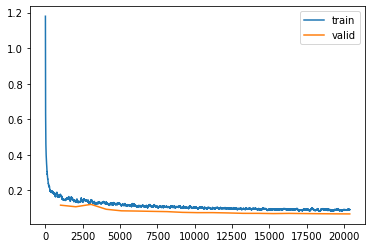

In [ ]:


lr_max = LR_MAX 

learn = timm_unet_learner(dls, 'efficientnet_b1', metrics = [Dice(), foreground_acc], cbs=CSVLogger())

learn.fit_one_cycle(
    20,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
)


learn.recorder.plot_loss()

learn.save('xview2_effnet_unet_learner',  with_opt=True)
learn.save('/content/drive/My Drive/cv/cv_527/xview_data/learners_model/eff_unet_learner',  with_opt=True)
learn.export(fname='/content/drive/My Drive/cv/cv_527/xview_data/learners_model/eff_unet_learner_export.pkl', pickle_module=pickle, pickle_protocol=2)


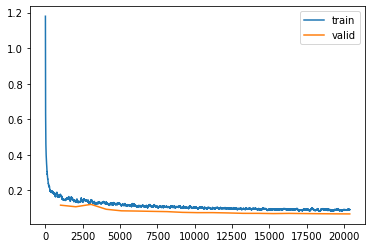

In [ ]:
learn.recorder.plot_loss()


In [ ]:
df = learn.csv_logger.read_log()
# learn.callbacks.append(partial(callbacks.CSVLogger, append=True))

In [ ]:
dls.train.show_batch()

In [ ]:
learn.all_batches()

In [ ]:
tiles.summary(path)


Setting-up type transforms pipelines
/content/drive/My Drive/cv/cv_527/xview_data/train/img_tiles3/guatemala-volcano_00000000_pre_disaster_0_0.png
train_idxs, valid_idxs  28476 3200
train_files pre  28476
train_files  16310
train_files tot_len  28464
valid_files  [Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_0_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_1.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_2.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_1_3.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_0.png'), Path('img_tiles3/hurricane-florence_00000032_pre_disaster_2_1.png'), Path('img_tiles3/hurricane-florence_00000032_

In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(16310, 3192)

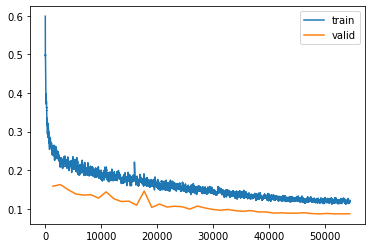

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.load('best-model');

In [ ]:
probs,targets,preds,losses = learn.get_preds(dl=dls.valid,
                                             with_loss=True,
                                             with_decoded=True,
                                             act=None)

In [ ]:
loss_sorted = torch.argsort(losses, descending=True)
n = len(loss_sorted)

In [ ]:
#collapse
def show_single_pred(index:int):
  fig, ax = plt.subplots(1, 4, figsize=(20,5))
  dls.valid_ds[index][0].show(ctx=ax[0]);
  ax[0].set_title("Input")
  show_at(dls.valid_ds, index, cmap='Blues', ctx=ax[1]);
  ax[1].set_title("Target")
  preds[index].show(cmap='Blues', ctx=ax[2]);
  ax[2].set_title("Prediction Mask")
  probs[index][1].show(cmap='viridis', ctx=ax[3]);
  ax[3].set_title("Building class probability")

In [ ]:
#collapse
for idx in loss_sorted[:10]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

Tile #2662, loss: 0.01572726108133793
Tile #1573, loss: 0.01564083993434906
Tile #1296, loss: 0.015631940215826035


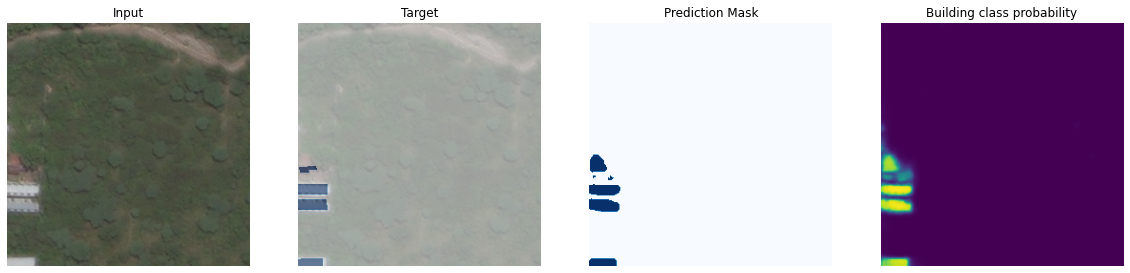

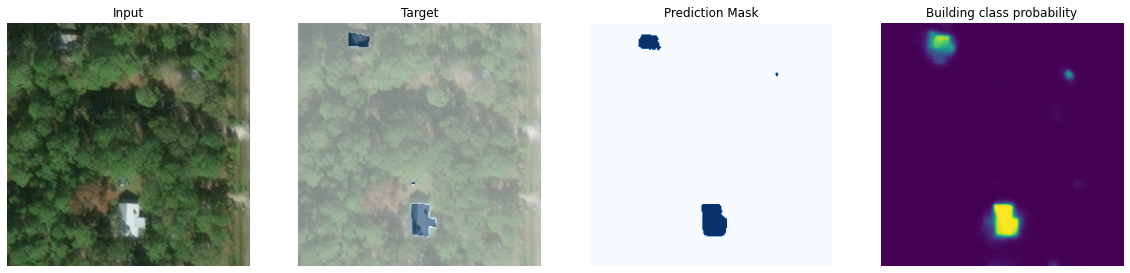

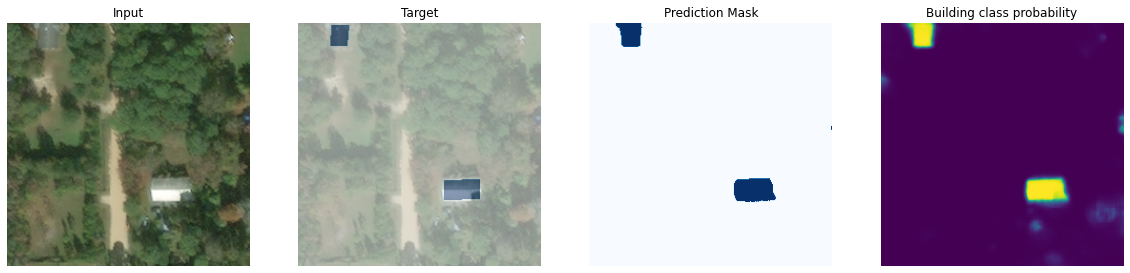

In [ ]:
#collapse
for idx in loss_sorted[n//2-1:n//2+2]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

The model tends to merge small buildings into larger blobs, and there are several false positives. But there are also some quite good predictions, picking up buildings that are hard even for the human eye to pick up.

### Plot some examples with low losses

Tile #733, loss: 6.0310298977128696e-09
Tile #2368, loss: 4.919603835418229e-09
Tile #2372, loss: 4.051529778337226e-09


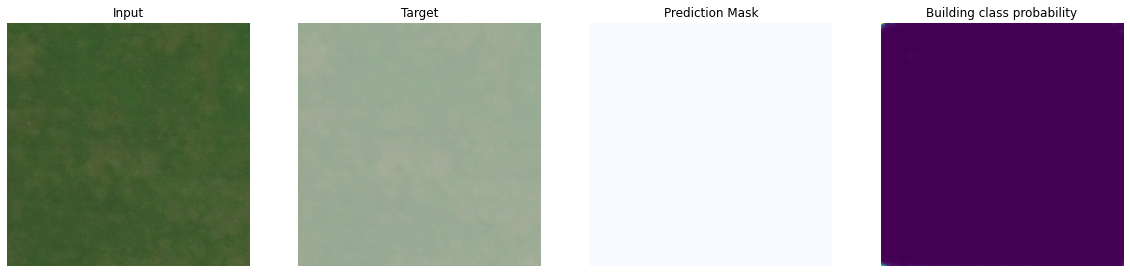

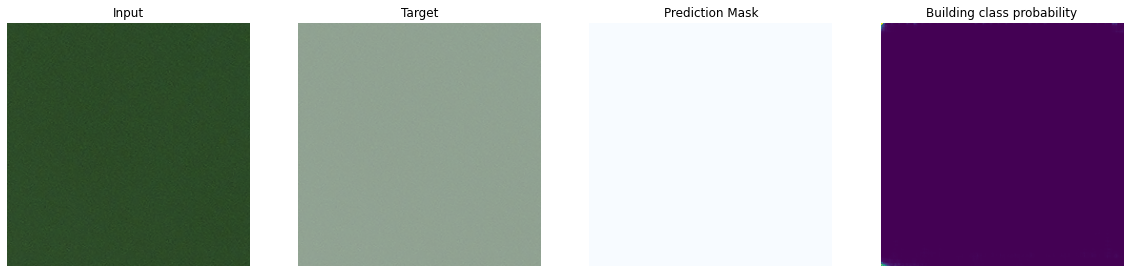

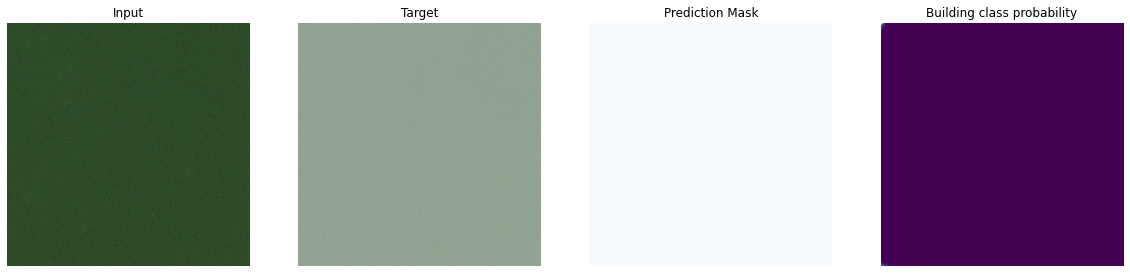

In [ ]:
#collapse
for idx in loss_sorted[-21:-18]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

In [ ]:
#collapse
def save_predictions(scene, path=path) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  tiles = get_image_files(path/'img_tiles').sorted()
  for i in range(16):
    tile_preds = learn.predict(tiles[i])
    to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')


#collapse
def save_predictions(image) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  tile_preds = learn.predict(image)
  to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{image.name}')
  # if not os.path.exists(output_folder):
  #   os.makedirs(output_folder)
  # tiles = get_image_files(path/'img_tiles').sorted()
  # for i in range(16):
  #   tile_preds = learn.predict(tiles[i])
  #   to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')

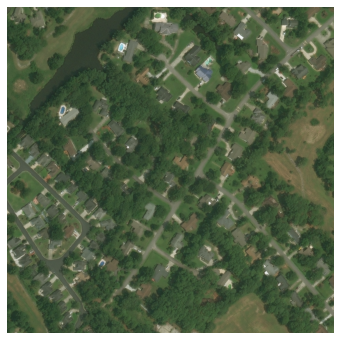

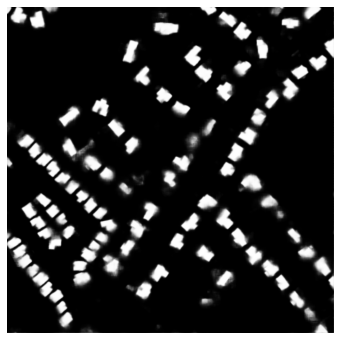

In [ ]:
# image.show()
# show_image(image)
output_folder = path/'predicted_tiles'
show_image(PILImage.create(image), figsize=(6,6));
show_image(PILImage.create(output_folder/f'{image.name}'), figsize=(6,6));

In [ ]:
save_predictions(image)

Helper function to show several tiles as a large image:

In [ ]:
#collapse
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.

    Source: https://stackoverflow.com/a/16873755
    """
    try: # with color channel
      n, nrows, ncols, c = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols, c)
                .swapaxes(1,2)
                .reshape(h, w, c))
    except ValueError: # without color channel
      n, nrows, ncols = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols)
                .swapaxes(1,2)
                .reshape(h, w))

Load saved predictions:

In [ ]:
#collapse
def get_saved_preds(scene, path=path):
  "Load saved prediction mask tiles for a scene and return image + assembled mask"
  image_file = (path/scene/'images_masked').ls()[0]
  image = load_image(image_file)

  mask_tiles = get_image_files(path/scene/'predicted_tiles').sorted()
  mask_arrs = np.array(list(maps(partial(load_image, mode="L"), np.asarray, mask_tiles)))
  mask_array = unblockshaped(np.array(mask_arrs), 1020, 1020)

  return (image, mask_array)

Show image + stitched predictions:

In [ ]:
#collapse
def show_complete_preds(image, mask_array, scene):
  "Source: https://github.com/CosmiQ/CosmiQ_SN7_Baseline/blob/master/notebooks/sn7_baseline.ipynb"
  figsize = (25, 16)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
  _ = ax0.imshow(image)
  ax0.set_xticks([])
  ax0.set_yticks([])
  ax0.set_title('Image')
  _ = ax1.imshow(mask_array, cmap='viridis')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title('Prediction Mask')
  plt.suptitle(scene)
  plt.tight_layout()
  plt.savefig(os.path.join(path, scene + '_im0+mask0+dice575.png'))
  plt.show()

In [ ]:
show_complete_preds(*get_saved_preds(scene), scene)